# Neural Networks

This notebook will attempt to train some Neural Networks on the Training data and save it for later use

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we are going to begin looking at training some neural networks.

I have tried to go through several U-net tutorials - all of which failed. I suspect there is a combination of problems affecting me:

- The data-sets are not clean or not accessible

- The implementation is complicated and built on old dependencies

- there is too much data being brought in for training at one time

To try and overcome these challenges - I am going to load a single folder from our data-set into some training variables, and attempt to train a model on just those. I am unable to do an example tutorial - so I am hoping for the best with my implementation

# Imports

In [1]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

# Load images into variables

We will be going to our training data and fetching 1 folder for our x and y training variables:

In [2]:
training_data_directory = getcwd() + "\\..\\..\\" + "COMP700_Training_GT"
desired_directory = ""
training_data_all_directories = []

# cycle up until we hit an "X"
for root, dirs, files in walk(training_data_directory):
    desired_directory = root
    if (dirs[0] == "X"):
        break

print(desired_directory)


c:\Users\G5\Documents\GitHub\COMP700\..\..\COMP700_Training_GT\BF-C2DL-HSC\BF-C2DL-HSC\01


We know that this variable desired_directory contains 2 folders: X and Y, so we can generate our X and Y paths now

In [3]:
x_training_paths = []
y_training_paths = []

for root, dirs, files in walk(desired_directory):
    if ("X" in root):
        x_training_paths = files
    else:
        y_training_paths = files

print("Length of X Training:", len(x_training_paths))
print("Length of Y Training:", len(y_training_paths))

# update the paths:

for i in range(len(x_training_paths)):
    x_training_paths[i] = desired_directory + "\\X\\" + x_training_paths[i]
    y_training_paths[i] = desired_directory + "\\Y\\" + y_training_paths[i]

Length of X Training: 49
Length of Y Training: 49


We can now try to write those images into an array of images:

In [4]:
x_training_images = []
y_training_images = []

for i in range(len(x_training_paths)):
    x_training_images.append( cv2.imread(x_training_paths[i]) )
    y_training_images.append( cv2.imread(y_training_paths[i]) )

Let's now try show these images side by side to verify results:

Shape: (1010, 1010, 3)


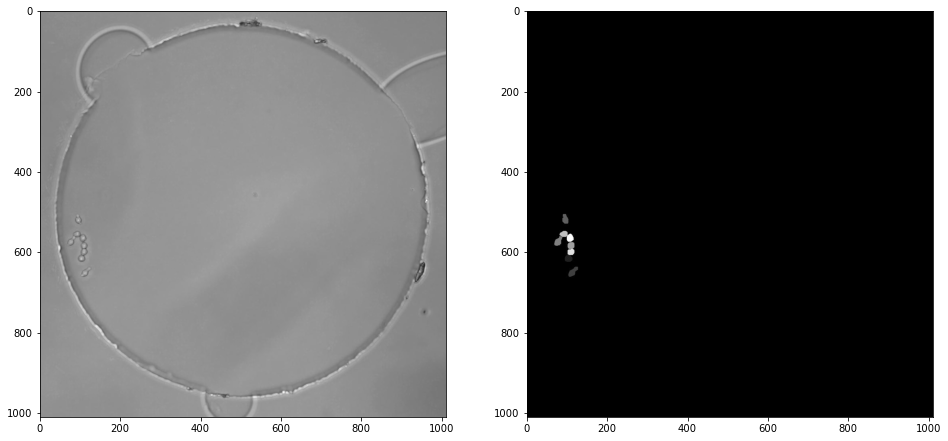

In [5]:
from random import randint

index = randint(0, len(x_training_images) - 1)
print("Shape:", y_training_images[index].shape)

fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(x_training_images[index])

plt.subplot(1, 2, 2)
plt.imshow(y_training_images[index])

plt.show()

Okay! We have taken a very small sample of images and loaded them correctly. We can now try train a simple U Net model and see if it will run. Hopefully it will...

# Designing the U-Net Model

In [18]:
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, Lambda
from tensorflow.python.keras import backend as K

In [37]:
def build_model(input_layer, start_neurons):
    print(1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    print(2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    print(3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    print(4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    print(5)
    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    print(5)
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    print(6)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    print(7)
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    print(8)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    print(9)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    print(10)
    return output_layer



In [31]:
image_shape = (y_training_images[0]).shape
print(image_shape)
print(image_shape[0])

(1010, 1010, 3)
1010


In [56]:
input_layer = Input(image_shape)
output_layer = build_model(input_layer, 2)

1
2
3
4
5
5
6
7


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 504, 504, 4), (None, 505, 505, 4)]

In [51]:
from tensorflow.python.keras import layers, Input, Model
from tensorflow.keras.layers import BatchNormalization


def get_model(img_size, num_classes):
    # inputs = Input(shape=img_size + (3,))
    inputs = Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [52]:
# Build model
model = get_model(image_shape, 3)
model.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'batch_normalization/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_1/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_1/beta:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda